# How-to: Build a pet detector model in an hour
This is mostly inspired by a fast.ai MOOC: [Practical Deep Learning for Coders](https://course.fast.ai/).It used a top-down approach teaching the deep learning. Lesson 1 and 2 will directly build several the state of the art deep learning models by a few lines of code.

In this notebook, my goal is to train a model to tell the difference of my cat: Albus, a silver shaded british shorthair from all other british short hairs. There is little pratical utility of the model, though it can be extended to something like pet finder using cameras including CCTC, phone's camera etc to help people find their missing pet.

As a reader, you just need some basic understanding of python (or similar) and really limited experience of coding such as variable assignment, import libraries, calling some functions. I will explain every step in this notebook of what it's achieving.

## Import your libraries
This is some basic python code import fastai/fastbook libraries (built by fast.ai team) to your jupyter notebook so that you can use all classes, functions in the libraries. One thing you might notice, it's generally a bad habit to `import *`, but according to fast.ai mooc, they pay extra attention on this, and it only imports necessary artifacts into the notebook, so you don't have to worry to much about it.

In [1]:
from fastbook import *
from fastai.vision.widgets import *

## Prepare your data 
In this step, it will prepare your training data.
1. For my pet Albus, I upload around 150 pictures into a folder `british_shorthair/albus`.
2. For the not_albus part, I use bing image search API to find around 150 silver shaded british shorthair images and download them into `british_shorthair/albus`. More details about bing image search
> To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it)
3. Once you download data from internet, it's possble some of images are corrupted. Thus, I use verify_images provided by fast.ai to verify all of images and unlink failures.

In [2]:
silver_british_shorthair_path = Path('british_shorthair')

In [3]:
# In order to use bing image search set the key
key = os.environ.get('AZURE_SEARCH_KEY', 'xx')

In [4]:
results = search_images_bing(key, 'sliver shaded british shorthair')

In [5]:
if not silver_british_shorthair_path.exists():
    silver_british_shorthair_path.mkdir()
    dest = (silver_british_shorthair_path/'not_albus')
    dest.mkdir(exist_ok=True)
    download_images(dest, urls=results.attrgot('contentUrl'))

In [6]:
fns = get_image_files(silver_british_shorthair_path)

In [7]:
# clean up some corrupted images if any
failed = verify_images(fns)

In [19]:
# unlink those images
failed.map(Path.unlink)

(#0) []

In [21]:
# Let's take a look at our data
(silver_british_shorthair_path/'not_albus').ls()

(#125) [Path('british_shorthair/not_albus/00000099.jpeg'),Path('british_shorthair/not_albus/00000047.jpg'),Path('british_shorthair/not_albus/00000055.jpg'),Path('british_shorthair/not_albus/00000063.jpeg'),Path('british_shorthair/not_albus/00000107.jpg'),Path('british_shorthair/not_albus/00000061.jpeg'),Path('british_shorthair/not_albus/00000110.jpg'),Path('british_shorthair/not_albus/00000112.jpeg'),Path('british_shorthair/not_albus/00000147.jpg'),Path('british_shorthair/not_albus/00000103.jpg')...]

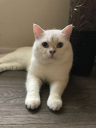

In [23]:
not_albus_img = Image.open(silver_british_shorthair_path/'not_albus/00000099.jpeg')
not_albus_img.to_thumb(128, 128)

In [24]:
(silver_british_shorthair_path/'albus').ls()

(#149) [Path('british_shorthair/albus/IMG_20200726_223920.jpg'),Path('british_shorthair/albus/IMG_20200722_094159.jpg'),Path('british_shorthair/albus/IMG_20201020_185137.jpg'),Path('british_shorthair/albus/IMG_20200119_211456.jpg'),Path('british_shorthair/albus/IMG_20200516_162728.jpg'),Path('british_shorthair/albus/IMG_20201011_230014.jpg'),Path('british_shorthair/albus/IMG_20201024_222227.jpg'),Path('british_shorthair/albus/IMG_20201101_184418.jpg'),Path('british_shorthair/albus/IMG_20210223_112905.jpg'),Path('british_shorthair/albus/IMG_20201020_185135.jpg')...]

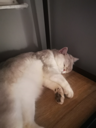

In [25]:
albus_img = Image.open(silver_british_shorthair_path/'albus/IMG_20200726_223920.jpg')
albus_img.to_thumb(128, 128)

## Train your model
In the following code cell, it only contains 4 lines of code but it does quite a lot:
1. Line 1: It prepares your data for training your model. It returns a DataBlock which is a fast.ai class 
  1. `blocks=(ImageBlock, CategoryBlock)`: It tells datablock that the input data is image and label is category 
  2. `get_items=get_image_files`: it means when loading input item, it will use get_image_files function to load the data
  3. `splitter=RandomSplitter(valid_pct=0.2, seed=42)`: it means that a randomation split will be performed to split your data into training (80%) and validation (20%). Seed will guarantee everytime it does a separation, the result will be the same.
  4. `get_y=parent_label`: it teams when load label, it will find the image's parent folder name as the label name, which is a common way to organize the data
  5. `item_tfms=RandomResizedCrop(224, min_scale=0.5)`: It applies item-wise transformation, which randomly resize and crop you image with size 224 px and minimum 50% of original image. 
  6. `batch_tfms=aug_transforms()`: It's using image augmentation technics to transform batch of images. It will flip, twist, adjust different stats of your images to generate "new" images for training purpose so that model can learn from different perspectives.
8. Line 2: It loads the actual data from your path
9. Line 3: We use a cnn learner with our data, and resnet18 architecture and use error rate as our metrics. The architecture in our case is not supper important and it's a deep residual network pretrained on imagenet (more on https://pytorch.org/hub/pytorch_vision_resnet/). For error rate, you will see that at each epoch (iteration) of training, what percentage of images that model makes mistake predict the correct label on validation set.
10. Line 4: it uses transfer learning technics and you don't need to train the model from scatch. Instead, you just need to call fine tune for 4 epochs on your training data which saves us a lot of time and reduces the requirements on the number of images we need to train a good model.
  

In [9]:
# Train the model using cnn learner
# Using transfer learning tactic since I don't have enough albus picture to train
british_sh = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = british_sh.dataloaders(silver_british_shorthair_path)
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.217437,3.258252,0.425926,00:18


epoch,train_loss,valid_loss,error_rate,time
0,0.540694,1.086071,0.388889,00:19
1,0.425827,0.172585,0.055556,00:18
2,0.306371,0.045891,0.037037,00:18
3,0.277176,0.029750,0.000000,00:19


## Checkout how your model perform
This section helps you quick understand how your model perform by showing confusion matrix: compare the model prediction against the actual label. As we can see, our model is pretty good at predicting albus!

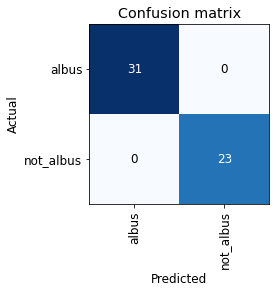

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Export you model
This step is not necessary if you don't want to use your model anywhere else. However, if you do, exporting your model to the pickle format and loading it at somewhere else e.g. your web server, mobile app is really easy way to use your model.

In [26]:
# Export model
learn.export('albus-detector.pkl')

## Make predictions
I prepare some test data (which model never sees in training as well as in validation sets) to see if model can actually predict on those images. As the result, for two cases, it predicts correct answer. However, you can prepare more test data to evaluate your model!

In [12]:
# Test the model with test data
print(learn.predict('albus_test/IMG_20190328_193913.jpg'))
print(learn.predict('albus_test/not_albus_1.jpeg'))

('albus', tensor(0), tensor([9.9960e-01, 3.9629e-04]))


('not_albus', tensor(1), tensor([0.0128, 0.9872]))


## Build some simple UI widgets 
This part is totally optional. It's fun to have some interaction UI widgets to
1. Upload a photo from you computer
2. Shows the prediction as well as how confident it is

As you can see in the following cell, I uploaded a pretty "tricky" image and model says it has high confidence (0.9993) that it's Albus!

In [13]:
# Load model from pkl file
learn_inf = load_learner('albus-detector.pkl', cpu=True)
learn_inf.predict('albus_test/IMG_20190328_193913.jpg')

('albus', tensor(0), tensor([9.9960e-01, 3.9629e-04]))

In [14]:
# Build a simple UI
btn_upload = widgets.FileUpload()
output = widgets.Output()
label = widgets.Label()

In [15]:
def on_click(change):
    img = PILImage.create(btn_upload.data[-1])
    output.clear_output()
    with output:
        display(img.to_thumb(128, 128))
    pred, index, prob = learn_inf.predict(img)
    label.value = f'Prediction: {pred} with probability {prob[index]:.04f}'

In [16]:
btn_upload.observe(on_click, names=['data'])

In [27]:
display(VBox([
    widgets.Label("Upload your picture to tell if it's albus"),
    btn_upload,
    output,
    label
]))